# RF for forecasting Bitcoin price

RF lacks ability to handle sequential nature of data, but may be better at splitting meaningful features. This will allow us to compare whether using a sequential model (i.e. LSTM) improves Bitcoin predictions.

In [3]:
import pandas as pd
import numpy as np
import datetime
from copy import deepcopy

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_pickle('features.pkl')
data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count,hour,price_open_-1,price_high_-1,price_low_-1,...,price_low_-58,price_close_-58,volume_traded_-58,trades_count_-58,price_open_-59,price_high_-59,price_low_-59,price_close_-59,volume_traded_-59,trades_count_-59
59,7154.97,7154.97,7154.97,7154.97,2.000000,2,0,7163.30,7163.30,7163.30,...,7168.30,7168.3,1.000000,2.0,7165.72,7165.72,7165.71,7165.71,0.021841,2.0
60,7161.20,7163.40,7161.20,7163.40,0.015800,2,0,7154.97,7154.97,7154.97,...,7170.50,7170.5,0.002000,1.0,7168.30,7168.30,7168.30,7168.30,1.000000,2.0
61,7154.98,7154.98,7154.97,7154.98,0.038357,3,0,7161.20,7163.40,7161.20,...,7169.20,7169.2,0.004000,2.0,7170.50,7170.50,7170.50,7170.50,0.002000,1.0
62,7154.98,7154.98,7154.98,7154.98,0.032201,1,0,7154.98,7154.98,7154.97,...,7169.20,7169.2,0.002000,1.0,7169.20,7169.20,7169.20,7169.20,0.004000,2.0
63,7154.97,7154.97,7154.97,7154.97,2.000000,1,0,7154.98,7154.98,7154.98,...,7165.72,7169.2,0.075433,3.0,7169.20,7169.20,7169.20,7169.20,0.002000,1.0


In [5]:
target = 'price_open'
features = list(data.columns)

for feat in features:
    scaler = MinMaxScaler()
    data[feat] = scaler.fit_transform(np.array(data[feat]).reshape(-1, 1))
    if feat == target:
        target_scaler = deepcopy(scaler)

features.remove(target)
        
data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count,hour,price_open_-1,price_high_-1,price_low_-1,...,price_low_-58,price_close_-58,volume_traded_-58,trades_count_-58,price_open_-59,price_high_-59,price_low_-59,price_close_-59,volume_traded_-59,trades_count_-59
59,0.183576,0.183576,0.291301,0.131212,0.030762,0.011494,0.0,0.331323,0.331323,0.419554,...,0.496536,0.300203,0.015381,0.011494,0.374246,0.374246,0.456659,0.267368,0.000336,0.011494
60,0.294076,0.333097,0.387221,0.238083,0.000243,0.011494,0.0,0.183576,0.183576,0.291301,...,0.530408,0.328093,0.000031,0.000000,0.420007,0.420007,0.496536,0.300203,0.015381,0.011494
61,0.183753,0.183753,0.291301,0.131339,0.000590,0.022989,0.0,0.294076,0.333097,0.387221,...,0.510393,0.311613,0.000061,0.011494,0.459028,0.459028,0.530408,0.328093,0.000031,0.000000
62,0.183753,0.183753,0.291455,0.131339,0.000495,0.000000,0.0,0.183753,0.183753,0.291301,...,0.510393,0.311613,0.000031,0.000000,0.435970,0.435970,0.510393,0.311613,0.000061,0.011494
63,0.183576,0.183576,0.291301,0.131212,0.030762,0.000000,0.0,0.183753,0.183753,0.291455,...,0.456813,0.311613,0.001160,0.022989,0.435970,0.435970,0.510393,0.311613,0.000031,0.000000


# grid search

In [71]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 50, 80],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# train test split
train, test = train_test_split(data, test_size=1 / 3, random_state=99)  # test_size=0.2

In [72]:
%%time
# Fit the grid search to the data
grid_search.fit(train[features], train[target])

print('Best params: ', grid_search.best_params_)

best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  9.1min finished


Best params:  {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
CPU times: user 10.4 s, sys: 807 ms, total: 11.2 s
Wall time: 9min 10s


# inspect results

In [73]:
%%time

# Create a based model
# rf = RandomForestRegressor(bootstrap=True, max_depth=50, max_features=3, min_samples_leaf=3, 
#                            min_samples_split=8, n_estimators=200)
rf = best_grid

# train test split
train, test = train_test_split(data, test_size=1 / 3, random_state=99)  # test_size=0.2

rf.fit(train[features], train[target])

CPU times: user 3.33 s, sys: 201 ms, total: 3.53 s
Wall time: 3.72 s


RandomForestRegressor(max_depth=80, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=200)

In [74]:
test_features = test[features]
test_labels = test[target]

# make prediction
predictions = rf.predict(test_features)    
# rescale back to original
predictions_unscaled = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
# get actual vals
actuals = target_scaler.inverse_transform(np.array(test_labels).reshape(-1, 1))

mae = mean_absolute_error(predictions_unscaled, actuals)
print("MAE, original scale: ", mae)

MAE, original scale:  0.82301779744025


Better than the simple neural net in example (which had MAE of ~2.12). However should see if LSTM sequential modelling improves.

## Examine feature importances

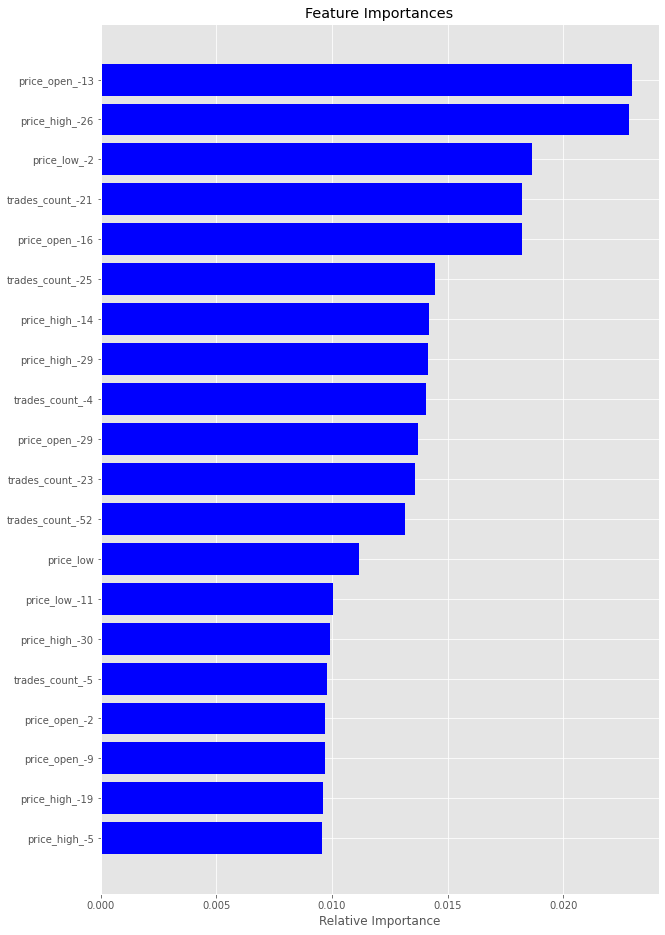

In [75]:
importances = rf.feature_importances_

df = pd.DataFrame(list(zip(importances, train.columns)), 
                  columns=['importance', 'feature']
                 ).sort_values('importance', ascending=False)

list1 = [df.iloc[i]['importance'] for i in indices]
list1.reverse()
list2 = [df.iloc[i]['feature'] for i in indices]
list2.reverse()

indices = list(range(0, 20))

plt.figure(figsize=(10, 16))
plt.title('Feature Importances')
plt.barh(indices, list1, color='b', align='center')
plt.yticks(range(len(indices)), list2)
plt.xlabel('Relative Importance')
plt.show()

## Examine predictions vs. actuals

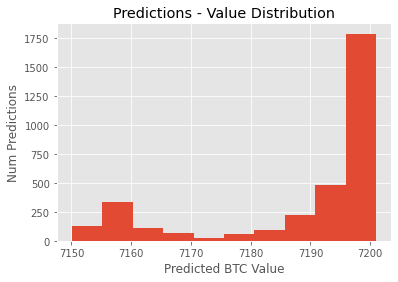

In [76]:
plt.hist(predictions_unscaled);
plt.title("Predictions - Value Distribution");
plt.xlabel("Predicted BTC Value");
plt.ylabel("Num Predictions");

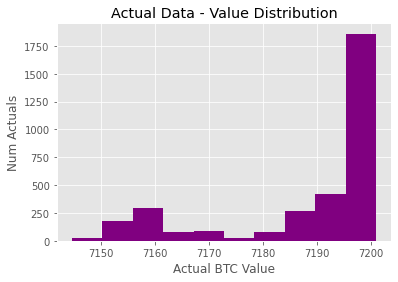

In [77]:
plt.hist(actuals, color='purple');
plt.title("Actual Data - Value Distribution");
plt.xlabel("Actual BTC Value");
plt.ylabel("Num Actuals");

# Conclusion

The RFregressor performs quite well, with an error of ~0.82 BTC MAE on a dataset averaging ~7188 BTC.